In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib import rc


warnings.filterwarnings(action='ignore')
rc('font', family='AppleGothic')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

In [3]:
path = './235745_parking_data/'
# train = pd.read_csv(path + "train.csv")
# test = pd.read_csv(path + "test.csv")
train = pd.read_csv(path+"train_df_errno.csv")
test = pd.read_csv(path+"test_df.csv")
sub = pd.read_csv(path + 'sample_submission.csv')
age = pd.read_csv(path + 'age_gender_info.csv')

train.shape, test.shape, sub.shape, age.shape

((2896, 15), (1008, 14), (150, 2), (16, 23))

In [4]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수',
       '10분내버스정류장수', '단지내주차면수', '등록차량수']

test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수',
       '10분내버스정류장수', '단지내주차면수']

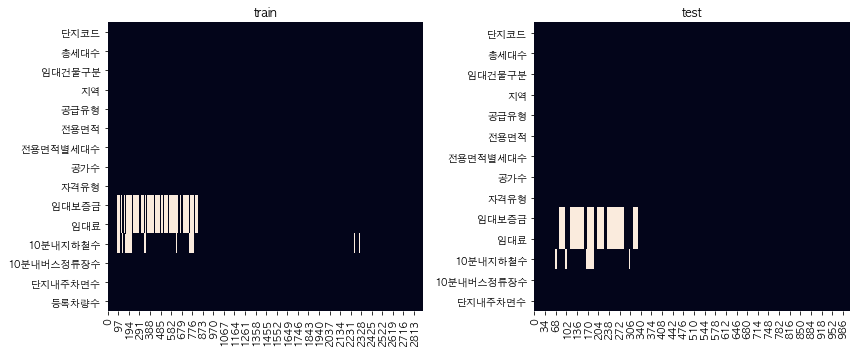

In [5]:
# 결측치 확인
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
sns.heatmap(train.isnull().T, cbar=False)
plt.title("train")
plt.subplot(122)
sns.heatmap(test.isnull().T, cbar=False)
plt.title("test")
plt.tight_layout()

In [6]:
all_df = pd.concat([train.drop("등록차량수",axis=1), test])
all_df.shape

(3904, 14)

In [7]:
all_df.isnull().sum()

# null_col = ["자격유형",임대보증금","임대료","10분내지하철수","10분내버스정류장수"]
# all_df[null_col].isnull().sum()

단지코드            0
총세대수            0
임대건물구분          0
지역              0
공급유형            0
전용면적            0
전용면적별세대수        0
공가수             0
자격유형            2
임대보증금         749
임대료           749
10분내지하철수      249
10분내버스정류장수      4
단지내주차면수         0
dtype: int64

In [8]:
all_df[all_df["자격유형"].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [9]:
null_grp = all_df.groupby(["단지코드","임대건물구분","지역","공급유형"])
grp1 = null_grp.get_group(('C2411', '아파트', '경상남도', '국민임대'))
grp2 = null_grp.get_group(('C2253','아파트','강원도','영구임대'))

grp1

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


In [10]:
grp2

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0


In [11]:
all_df.loc[196, "자격유형"] = "A"
all_df.loc[258, "자격유형"] = "C"
all_df[all_df["자격유형"].isnull()]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수


> '자격유형' 결측치 처리 완료

##  주차 수요 예측 LinearRegression 모델 적용하기
- train_acc, test_acc, MAE, MSE, RMSE 구해보기

In [12]:
# (2896, 15), (1008, 14)
train_df = all_df.iloc[:2896, :]
test_df = all_df.iloc[2896:,:]

train_df["등록차량수"] = train["등록차량수"]

train_df.shape, test_df.shape

((2896, 15), (1008, 14))

<AxesSubplot:xlabel='등록차량수', ylabel='Count'>

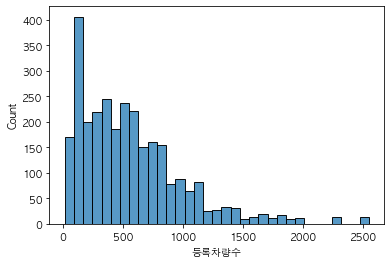

In [13]:
y = train_df["등록차량수"]
sns.histplot(y)

In [14]:
X = train_df.drop("등록차량수",axis=1)
X.isnull().sum()

단지코드            0
총세대수            0
임대건물구분          0
지역              0
공급유형            0
전용면적            0
전용면적별세대수        0
공가수             0
자격유형            0
임대보증금         569
임대료           569
10분내지하철수      211
10분내버스정류장수      4
단지내주차면수         0
dtype: int64

In [15]:
X = train_df.drop("등록차량수",axis=1)
X.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '10분내지하철수', '10분내버스정류장수', '단지내주차면수'],
      dtype='object')

In [16]:
# 데이터 나누기
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

sel = ['총세대수', '전용면적', '전용면적별세대수', '공가수','단지내주차면수']

X = train_df.drop("등록차량수",axis=1)[sel]
y = train_df["등록차량수"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=77)
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

train_acc, test_acc

(0.7843443035088982, 0.7853280239403924)

In [17]:
# pred, y_test
dat = {"y_test":y_test,"pred":pred}
dat = pd.DataFrame(dat)
dat.reset_index(drop=True, inplace=True)
dat

,y_test,pred
0,586.0,557.544558
1,568.0,440.196428
2,62.0,119.354256
3,156.0,231.432699
4,561.0,637.981382
...,...,...
719,1433.0,1174.705540
720,873.0,987.491435
721,1117.0,999.056924
722,365.0,489.014496


In [18]:
dat["err"] = dat["y_test"] - dat["pred"]
dat["err_sqr"] = dat["err"]**2
dat["err_abs"] = abs(dat["err"])
dat

,y_test,pred,err,err_sqr,err_abs
0,586.0,557.544558,28.455442,809.712196,28.455442
1,568.0,440.196428,127.803572,16333.753029,127.803572
2,62.0,119.354256,-57.354256,3289.510672,57.354256
3,156.0,231.432699,-75.432699,5690.092016,75.432699
4,561.0,637.981382,-76.981382,5926.133221,76.981382
...,...,...,...,...,...
719,1433.0,1174.705540,258.294460,66716.028274,258.294460
720,873.0,987.491435,-114.491435,13108.288689,114.491435
721,1117.0,999.056924,117.943076,13910.569270,117.943076
722,365.0,489.014496,-124.014496,15379.595315,124.014496


In [19]:
mse = np.mean(dat["err_sqr"])
mae = np.mean(dat["err_abs"])
rmse = np.sqrt(mse)

mse, mae, rmse

(39233.94447606905, 142.78315493048893, 198.07560292996473)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression

sel = ['총세대수', '전용면적', '전용면적별세대수', '공가수','단지내주차면수']

X = train_df.drop("등록차량수",axis=1)[sel]
y = train_df["등록차량수"]

normalize_X = MinMaxScaler().fit_transform(X)  
ex_X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(normalize_X)  

X_train, X_test, y_train, y_test = train_test_split(ex_X, y, random_state=42)


# LinearRegression
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print("LinearRegression")
print("train_score : {:.4f}".format(lr.score(X_train, y_train)))
print("test_score : {:.4f}".format(lr.score(X_test, y_test)))
dat_lr = {"y_test":y_test, "pred":pred_lr}

# Lasso
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
pred_ls = lasso.predict(X_test)
print("\nLasso")
print("train_score : {:.4f}".format(lasso.score(X_train, y_train)))
print("test_score : {:.4f}".format(lasso.score(X_test, y_test)))
dat_ls = {"y_test":y_test, "pred":pred_ls}

# Ridge
ridge = Ridge(alpha=0.1).fit(X_train, y_train)
pred_rd = ridge.predict(X_test)
print("\nRidge")
print("train_score : {:.4f}".format(ridge.score(X_train, y_train)))
print("test_score : {:.4f}".format(ridge.score(X_test, y_test)))
dat_rd = {"y_test":y_test, "pred":pred_rd}



LinearRegression
train_score : 0.8354
test_score : 0.7989

Lasso
train_score : 0.8350
test_score : 0.7964

Ridge
train_score : 0.8321
test_score : 0.8052


In [21]:
dat_lr = pd.DataFrame(dat_lr)
dat_lr.reset_index(drop=True, inplace=True)
# dat_lr

dat_ls = pd.DataFrame(dat_ls)
dat_ls.reset_index(drop=True, inplace=True)
# dat_ls

dat_rd = pd.DataFrame(dat_rd)
dat_rd.reset_index(drop=True, inplace=True)
# dat_rd

In [22]:
dat_lr["err"] = dat_lr["y_test"] - dat_lr["pred"]
dat_lr["err_sqr"] = dat_lr["err"]**2
dat_lr["err_abs"] = abs(dat_lr["err"])

mse = round(np.mean(dat_lr["err_sqr"]),2)
mae = round(np.mean(dat_lr["err_abs"]),2)
rmse = round(np.sqrt(mse),2)

lr = [mse, mae, rmse]
lr

[37773.54, 133.35, 194.35]

In [23]:
dat_ls["err"] = dat_ls["y_test"] - dat_ls["pred"]
dat_ls["err_sqr"] = dat_ls["err"]**2
dat_ls["err_abs"] = abs(dat_ls["err"])

mse = round(np.mean(dat_ls["err_sqr"]),2)
mae = round(np.mean(dat_ls["err_abs"]),2)
rmse = round(np.sqrt(mse),2)

ls = [mse, mae, rmse]
ls

[38256.78, 133.35, 195.59]

In [24]:
dat_rd["err"] = dat_rd["y_test"] - dat_rd["pred"]
dat_rd["err_sqr"] = dat_rd["err"]**2
dat_rd["err_abs"] = abs(dat_rd["err"])

mse = round(np.mean(dat_rd["err_sqr"]),2)
mae = round(np.mean(dat_rd["err_abs"]),2)
rmse = round(np.sqrt(mse),2)

rd = [mse, mae, rmse]
rd

[36587.67, 133.25, 191.28]

#### 일단 ridge 모델이 가장 좋다!

In [30]:
X_test.shape

(724, 20)

In [33]:
# ridge.predict()

sel = ['총세대수', '전용면적', '전용면적별세대수', '공가수','단지내주차면수']

test_sel = test[sel]
# test_sel.shape

normalize_test = MinMaxScaler().fit_transform(test_sel)  
ex_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(normalize_test)  

ex_test.shape

(1008, 20)

In [34]:
pred = ridge.predict(ex_test)
print(type(pred))
print(pred.shape)

<class 'numpy.ndarray'>
(1008,)


In [40]:
test

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000,249930,0.0,2.0,683.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000,296780,0.0,2.0,683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,C1267,675,아파트,경상남도,행복주택,36.77,126,38.0,L,-,-,0.0,1.0,467.0
1004,C2189,382,아파트,전라북도,국민임대,29.19,96,45.0,H,6872000,106400,0.0,2.0,300.0
1005,C2189,382,아파트,전라북도,국민임대,29.19,20,45.0,H,6872000,106400,0.0,2.0,300.0
1006,C2189,382,아파트,전라북도,국민임대,39.45,202,45.0,H,13410000,144600,0.0,2.0,300.0


In [41]:
test['등록차량수'] = pred
test['단지별차량수평균'] = test.groupby("단지코드")['등록차량수'].transform(np.mean)
test_new = test.drop_duplicates(['단지코드'], keep='first').reset_index()
test_new.head()

,index,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,10분내지하철수,10분내버스정류장수,단지내주차면수,등록차량수,단지별차량수평균
0,0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0,667.882526,693.875846
1,8,C1128,1354,아파트,경기도,국민임대,39.79,368,9.0,H,22830000,189840,0.0,3.0,1216.0,1329.611769,1310.852164
2,17,C1456,619,아파트,부산광역시,국민임대,33.40,82,18.0,A,19706000,156200,0.0,16.0,547.0,493.399734,528.881138
3,26,C1840,593,아파트,전라북도,국민임대,39.57,253,7.0,A,14418000,108130,0.0,3.0,543.0,579.506458,585.562801
4,30,C1332,1297,아파트,경기도,국민임대,39.99,282,11.0,H,28598000,203050,0.0,2.0,1112.0,1175.867164,1178.344351


In [50]:
set(sub['code']) - set(test_new["단지코드"])

{'C1327', 'C2335', 'C2675'}

In [61]:
final_df = pd.merge(sub, test_new, left_on='code', right_on='단지코드',how='left')
final_df = final_df[["code","단지별차량수평균"]]
final_df.columns= ["code","num"]
final_df.to_csv("ridge_1st_submission.csv", index=False)
final_df

,code,num
0,C1072,693.875846
1,C1128,1310.852164
2,C1456,528.881138
3,C1840,585.562801
4,C1332,1178.344351
...,...,...
145,C2456,283.030836
146,C1266,364.311378
147,C2152,77.321418
148,C1267,254.201531


> 결과 : 115.29311 (207위)